# An Earth-Venus-Earth Link Budget from Open Research Institute
This document contains a detailed link budget analysis for Earth-Venus-Earth (EVE) communications. It begins with a Python dataclass for each fixed earth station. Dataclasses are a type of Python object where only variables are declared. No methods are included. The site-specific dataclasses have parameters that are true for the site regardless of the target. Following the site-specific dataclasses are link budget classes, which contain target-specific values and methods that return various gains and losses. The most important output of a link budget object is a carrier to noise ratio at a particular receive bandwidth. A link budget class inherits a particular site dataclass. The site-specific dataclasses and the link budgets can be mixed and matched. This gives flexibility, as a link budget for a particular target, such as EVE, can be calculated for different sites by having that link budget inherit different site-specific dataclasses. 

## EVE compared to EME
The communications mode most similar to EVE is Earth-Moon-Earth (EME). EVE is more complex than EME communications due to several factors:

1. Much greater distances involved
2. Greater variability in the distances involved
3. Doppler rate of change due orbital positions of Earth and Venus changing with respect to each other
4. Different signal reflection characteristics from Venus compared to the Moon
5. Doppler spreading

## Contributors
Including but not limited to Michelle Thompson, Matthew Wishek, Paul Williamson, Rose Easton, Thomas Telkamp, Pete Wyckoff. Questions about this document? Please file an issue in the repository or write hello at operesearch dot institute.

# ORI Earth-Venus-Earth Communications Development Roadmap
Note: the checkboxes for each task listed below _may not_ automatically render if you are viewing this document on GitHub. If you want to see completed vs. uncompleted tasks, then you will need to see the PDF rendering of this document, or render it to a viewer yourself. 

## Phase 1: Foundation and Research (3-4 months)
### Documentation and Requirements
- [x] Document full link budget analysis (this notebook)
- [x] Compile SDR Capabilities (zc706/adrv9009 or any partner SDR system)
- [ ] Create detailed Doppler analysis document
- [ ] Define custom mode specifications (CNR in 1Hz now known)
- [ ] Write FPGA requirements document

#### zc706/adrv9009 FPGA Development Board Capabilities
ADRV9009 capabilities:

-Frequency range: 75 MHz to 6 GHz (covers our 1296 MHz)
-Observation bandwidth: up to 200 MHz (plenty for our ~600 kHz Doppler range)
-12-bit ADC
-Low noise performance
-Direct sampling capability

The Zynq 7 FPGA on the zc706 provides:

-DSP slices: 900
-Block RAM: 555 × 36 Kb
-LUTs: 218,600
-Flip-flops: 437,200

#### zcu102/adrv9009 FPGA Development Board Capabilities
ADRV9009 capabilities:

-Frequency range: 75 MHz to 6 GHz (covers our 1296 MHz)
-Observation bandwidth: up to 200 MHz (plenty for our ~600 kHz Doppler range)
-12-bit ADC
-Low noise performance
-Direct sampling capability

UltraScale+ XCZU9EG on the zcu102 provides:

DSP Slices: 2,520 (vs 900 on zc706)
Block RAM: 1,824 × 36Kb (vs 555 on zc706)
UltraRAM: 960 Kb
LUTs: 548,160 (vs 218,600 on zc706)
Flip-flops: 1,096,320 (vs 437,200 on zc706)

-More parallel processing channels possible
-Better timing closure likely with UltraScale+ architecture
-UltraRAM provides additional buffer space for sample processing
-Higher achievable clock rates
-More room for future expansion/features
-Could implement more parallel demodulators for Doppler tracking

#### USRP X310



#### Detailed Doppler Analysis Document

#### Custom Mode Definition
In the case that no existing communications mode closes the link (see Evaluation of Modes cell below) we could design a custom "EVE-Mode" with:

- QPSK modulation as a baseline (good balance of spectral efficiency and robustness)
- ~5 kHz bandwidth (more than wide enough for short-term Doppler)
- Strong FEC (LDPC, Polar)
- Synchronization sequence designed for high Doppler rates
- Multiple parallel decoding paths

#### Custom Mode SDR Requirements
- Need high sample rate (>1.2 MSPS)
- Need Excellent phase noise performance
- 16-bit ADC minimum
- Very stable frequency reference

#### Custom Mode FPGA Specficiation



### Initial GNU Radio Development
- [ ] Basic flow graph implementation
- [ ] Simple Doppler tracking prototype
- [ ] Test with recorded or simulated signals/simulations
- [ ] Document processing chain

### Community Engagement
- [x] Present project on ORI channels
- [x] Recruit additional developers (mailing list, Slack)
- [x] Set up project definition and documentation (this document)

## Phase 2: Core Development (6-8 months)
### GNU Radio Implementation
- [ ] Complete mode implementation
- [ ] Doppler tracking refinement
- [ ] orbital prediction integration
- [ ] Performance monitoring tools
- [ ] User interface development

### FPGA Development
- [ ] DDC implementation?
- [ ] Initial Doppler tracking
- [ ] Memory interface design
- [ ] Basic demodulator implementation
- [ ] Testing framework development
- [ ] Does our AI/ML team have a role?

### Integration Planning
- [ ] SDR selection and acquisition: zc706/adrv9009, zcu102/adrv9009 or 9002, new hardware
- [ ] Interface definition for hardware
- [x] Test equipment requirements (Remote Labs confirmed)
- [ ] Performance measurement plans

## Phase 3: Integration and Testing (4-6 months)
### Hardware Integration
- [ ] SDR integration (do the work)
- [ ] FPGA bitstream testing (do the work)
- [ ] Timing verification (do the work)
- [ ] Performance measurements (yes, do the work)

### Software Integration
- [ ] GNU Radio to FPGA interface? 
- [ ] Control software development
- [ ] Monitoring tools - [ ] probably not required due to brevity of opportunities
- [ ] User interface refinement (standing orders)

### Testing Framework
- [ ] Automated test development (probably not needed but need to talk about)
- [ ] Performance verification (did it work or not)
- [ ] Doppler simulation testing (did our model turn out to be accurate)
- [ ] Link budget verification (did we close the link with expected margins)

## Phase 4: Optimization and Documentation (3-4 months)
### Performance Optimization (Vivado)
- [ ] FPGA resource optimization and utilization reports
- [ ] Processing chain refinement
- [ ] Doppler tracking improvements?
- [ ] Memory usage optimization

### Documentation
- [ ] User manual creation (HTML5 interface?)
- [ ] Installation guides
- [ ] Development documentation, articles, reports
- [ ] Performance reports, papers

### Community Resources
- [ ] Example configurations
- [ ] Tutorial development
- [ ] Test data publication
- [ ] Contribution guidelines

## Phase 5: Deployment and Validation (3-4 months)
### Field Testing
- [ ] Initial station setup (may be very narrow cases if remote access not available)
- [ ] Performance validation
- [ ] Doppler tracking testing
- [ ] System stability testing

### Final Documentation
- [ ] Test results publication
- [ ] Configuration guides
- [ ] Troubleshooting guides
- [ ] Performance reports

### Community Support
- [ ] Training materials
- [ ] Support documentation
- [ ] Schedule of next opportunity for communications attempts
- [ ] Future development plans

## Ongoing Activities
### Community Engagement
- [x] Regular progress updates (Inner Circle, email, published video recordings)
- [x] Technical presentations (IEEE vTools events)
- [ ] Conference participation
- [x] Developer meetings

### Development Support
- [x] Code review process (weekly meetups)
- [x] Bug tracking (Github Issues Tracker)
- [x] Feature requests (Slack, email, meetups)
- [ ] Performance monitoring

### Documentation Maintenance
- [ ] Regular documentation updates
- [ ] Performance reports
- [ ] Configuration Artifacts Recorded
- [ ] Best practices documentation

## Key Milestones
0. Jupyter Lab Notebook passes review
1. Initial GNU Radio prototype functional
2. First FPGA implementation complete
3. Basic Doppler tracking working
4. Full system integration achieved
5. First successful field tests
6. Release candidate testing complete
7. Production release with documentation

## Success Criteria
- [ ] Successful Doppler tracking at specified rates
- [ ] Reliable demodulation under varying conditions
- [ ] Meeting specified link budget parameters
- [ ] Complete, maintainable documentation
- [ ] Active community engagement
- [ ] Reproducible build process
- [ ] Comprehensive test coverage

## Risk Management
### Technical Risks
- [ ] SDR performance limitations
- [ ] FPGA resource constraints
- [ ] Doppler tracking challenges
- [ ] Integration complexities

### Mitigation Strategies
- [ ] Early prototyping
- [ ] Regular testing
- [ ] Performance monitoring
- [ ] Community feedback
- [x] Incremental development
- [x] Regular reviews

## Resource Requirements
### Hardware
- [x] Development SDRs
- [x] FPGA development boards
- [x] Test equipment
- [x] Antenna systems

### Software
- [x] FPGA development tools
- [x] GNU Radio environment
- [x] Testing frameworks
- [x] Documentation tools

### Personnel
- [x] FPGA developers
- [ ] GNU Radio developers
- [x] Documentation writers
- [x] Test engineers
- [x] Project coordinators

## Review Points
- [x] Weekly progress reviews
- [x] Monthly milestone assessments (Inner Circle Newsletter)
- [x] Community feedback sessions (vTools crosslisting, email list)
- [ ] Performance validation checks
- [ ] Documentation reviews

## Imports and Dataclass Definition

We import the python modules that we need for the project. 

We set up dataclasses using the naming format SiteNameLinkParameters. We use numbers we have been given from sites such as Deep Space Exploration Society (DSES), who asked for assistance with this project. This first part of our analysis sets the values that are true for these sites regardless of the celestial target. For example, 1296 MHz (23cm band) is a common frequency for EME communications, and is the starting point for EVE at DSES. Using a frequency closer to ~2450 MHz would give a bit better performance, and there are plans to move to 2304 MHz in 2026. Therefore, variables such as the frequency used at DSES site (tx_frequency_mhz) can be set in DSESLinkParameters data classes. 

In [84]:
# Cell 1: Imports and class definitions
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional

@dataclass
class DSESLinkParameters: #things that are true for the site regardless of the target
    # location of this dish in Google Earth is 38°22'51"N 103°09'22"W
    latitude: float = 38.380833 # from FCC converter
    longitude: float = -103.156111 # from FCC converter
    tx_frequency_mhz: float = 1296.0 # Transmit frequency
    tx_power_w: float = 1500.0 # Transmit power in watts
    tx_antenna_diameter_m: float = 18.29 # Transmit antenna diameter
    tx_antenna_efficiency: float = 0.69 # Transmit antenna efficiency
    rx_antenna_diameter_m: float = 18.29 # Receive antenna diameter
    rx_antenna_efficiency: float = 0.69 # Receive antenna efficiency
    tx_line_loss_db: float = 0.5 # provided
    rx_line_loss_db: float = 0.5 # provided
    pointing_error_deg: float = 0.01 # Needs to be moved from worksheet to here
    tracking_error_deg: float = 0.01 # Needs to be moved from worksheet to here
    lna_noise_figure_db: float = 0.4 # from datasheet for the Kuhne MKU LNA 132 AH SMA
    receiver_noise_bandwidth: float = 100e3 # operational receiver bandwidth. 
    c: float = 299792458  # Speed of light in m/s
    k: float = 1.380649e-23  # Boltzmann constant in J/K
    t0: float = 290  # Reference temperature in K
    

## EVELinkBudget Class
This link budget class is EVELinkBudget. It targets Venus as a reflective surface. We inherit site specific link parameters (SiteNameLinkParameters) as params and can call upon them in the class. We then set up all our EVE/Venus specific values and define the functions that we need in order to calculate this specific link budget. 

We add up all the gains and subtract the losses. This gives power at the receiver. We calculate the noise in our receive bandwidth, and subtract it from power at the receiver. This gives a carrier to noise ratio in dB. Our communications mode must be able to meet this CNR in order to close the link. 

In [85]:
# Define the EVE link budget here - [ ] # Venus specific
class EVELinkBudget: 
    def __init__(self, params: DSESLinkParameters):
        self.params = params

        # Venus characteristics
        self.venus_radius_km = 6051.8  # Venus radius in km
        self.venus_radar_albedo = 0.152  # see Venus radar albedo (Radio Echo Observations of Venus and Mercury at 23 cm Wavelength, 1965)
                                         # see Variations in the Radar Cross Section of Venus J. V. Evans Lincoln Laboratory,
                                         # Massachusetts Institute of Technology (Received 19 December 1967)

        
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency"""
        return self.params.c / (self.params.tx_frequency_mhz * 1e6)

    def venus_reflection_gain(self) -> float:
        """Calculate reflection gain from Venus surface
        Venus radar cross section = π * radius²"""
        # see also https://hamradio.engineering/eme-path-loss-free-space-loss-passive-reflector-loss/
        venus_radius_m = self.venus_radius_km * 1000
        radar_cross_section = np.pi * venus_radius_m**2
        return 10 * np.log10(radar_cross_section)

    def venus_reflection_loss(self) -> float:
        # use radar albedo for Venus to get this loss
        return 10 * np.log10(self.venus_radar_albedo)
    
    def tx_antenna_gain(self) -> float:
        """Calculate transmitter antenna gain"""
        efficiency = self.params.tx_antenna_efficiency
        diameter = self.params.tx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)
    
    def rx_antenna_gain(self) -> float:
        """Calculate receiver antenna gain"""
        efficiency = self.params.rx_antenna_efficiency
        diameter = self.params.rx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)

    def free_space_loss(self, distance_km: float, round_trip: bool = True) -> float:
        """Calculate free space loss, optionally for round trip
        
        Args:
            distance_km: Distance in kilometers
            round_trip: If True, calculate round trip loss (both directions)
        """
        wavelength = self.wavelength()
        distance_m = distance_km * 1000
        one_way_loss = 20 * np.log10(4 * np.pi * distance_m / wavelength)
        return one_way_loss * 2 if round_trip else one_way_loss
    
    def pointing_loss(self) -> float:
        """Calculate pointing loss"""
        pointing_error_rad = np.radians(self.params.pointing_error_deg)
        tracking_error_rad = np.radians(self.params.tracking_error_deg)
        total_error_rad = np.sqrt(pointing_error_rad**2 + tracking_error_rad**2)
        return -12 * (total_error_rad / self.antenna_beamwidth_rad())**2
    
    def antenna_beamwidth_rad(self) -> float:
        """Calculate antenna beamwidth in radians"""
        return 1.22 * self.wavelength() / self.params.tx_antenna_diameter_m
    
    def calculate_link_budget(self, distance_km: float) -> dict:
        """Calculate complete link budget for a given distance"""
        # Convert transmit power to dBW
        tx_power_dbw = 10 * np.log10(self.params.tx_power_w)
        
        # Calculate antenna gains (only once each for TX and RX)
        tx_gain = self.tx_antenna_gain()
        rx_gain = self.rx_antenna_gain()
        venus_gain = self.venus_reflection_gain()
        
        # Calculate losses
        fs_loss = self.free_space_loss(distance_km, round_trip=True)
        point_loss = self.pointing_loss()
        venus_loss = self.venus_reflection_loss()
        
        # Calculate received power (passive reflection scenario)
        rx_power = (
            tx_power_dbw 
            + tx_gain  # TX antenna gain
            + rx_gain  # RX antenna gain
            - fs_loss  # Two-way path loss
            - self.params.tx_line_loss_db  # reported TX line loss at site
            - self.params.rx_line_loss_db  # reported RX line loss at site
            - point_loss  # Pointing loss - needs attention
            - venus_loss  # Venus reflection loss
            + venus_gain  # Venus reflection gain
        )
        
        # Calculate system noise
        t_sys = 47.8 # copied over by hand from Tsys worksheet cell (scroll down)
        
        noise_dbw = 10 * np.log10(self.params.k * t_sys * self.params.receiver_noise_bandwidth)

        
        # Calculate CNR
        cnr = rx_power - noise_dbw
        
        return {
            'tx_power_dbw': tx_power_dbw,
            'tx_gain_db': tx_gain,
            'rx_gain_db': rx_gain,
            'free_space_loss_db': fs_loss,
            'pointing_loss_db': point_loss,
            'venus_reflection_loss_db': venus_loss,
            'venus_reflection_gain_db': venus_gain,
            'system_noise_temperature': t_sys,
            'rx_power_dbw': rx_power,
            'noise_dbw': noise_dbw,
            'cnr_db': cnr
        }

        

## Link Budget Calculator Setup
We fetch all the LinkParameters and then create a calculator instance by saying EVELinkBudget(params). 
We've specified the class of EVELinkBudget. We're now creating an object where we can call the various methods inside of that class, which includes our calculate_link_budget(). Since the distance to Venus varies quite a bit, this is a parameter we need to provide. 

Whenever we need to calculate the CNR for our link, we call cnr = calculator.calculate_link_budget(distance to Venus). 

In [86]:
# Cell 2: Create calculator instance
params = DSESLinkParameters()
calculator = EVELinkBudget(params)

## Effect of Distance on Received Power and Carrier-to-Noise Ratio

The variation in distance from Earth to Venus results in a large variation in the received power at the site and in the carrier to noise ratio at the site. This visualization shows the differences between the closest path and the furthest path for radio work. 

In [87]:
# Cell 3: Calculate for Earth-Venus distances
min_distance_km = 38_000_000  # Minimum Earth-Venus distance
max_distance_km = 261_000_000  # Maximum Earth-Venus distance

# Create distance array for plotting
distances = np.linspace(min_distance_km, max_distance_km, 1000)
cnrs = []
rx_powers = []

for dist in distances:
    results = calculator.calculate_link_budget(dist)
    cnrs.append(results['cnr_db'])
    rx_powers.append(results['rx_power_dbw'])

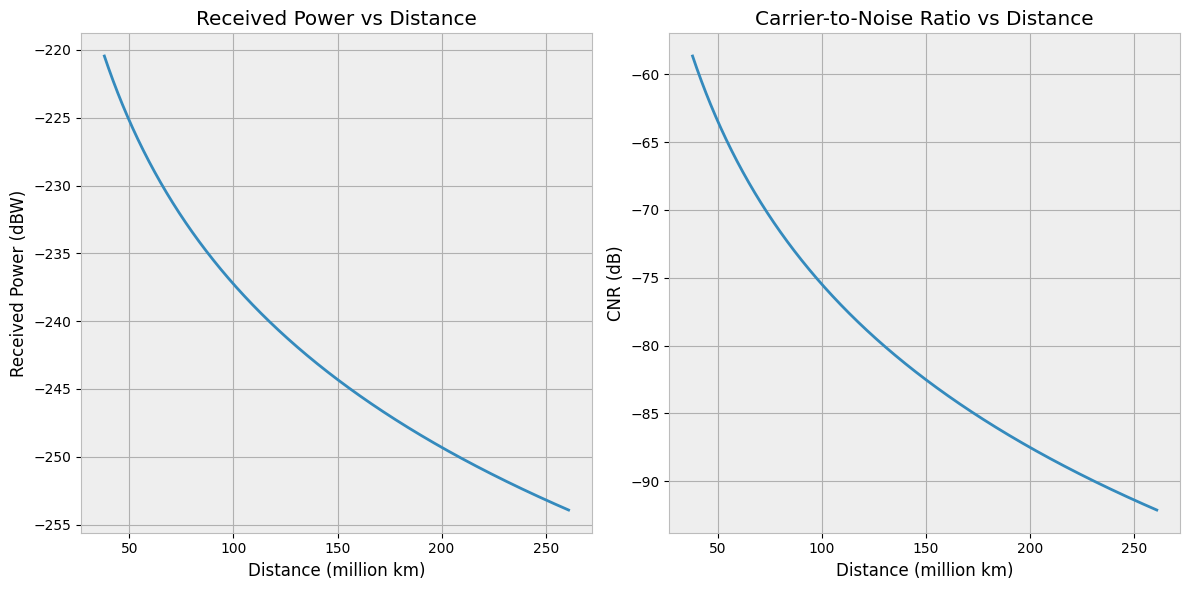

In [88]:
# Cell 4: Create plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(distances/1e6, rx_powers)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('Received Power (dBW)')
plt.title('Received Power vs Distance')

plt.subplot(1, 2, 2)
plt.plot(distances/1e6, cnrs)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('CNR (dB)')
plt.title('Carrier-to-Noise Ratio vs Distance')
plt.tight_layout()
plt.show()

## Pointing and Tracking Error Worksheets

Dish antennas have a narrow beamwidth. Pointing and tracking errors cost us in our link budget. This section models the pointing and tracking errors so that those amounts can be included in the link budget calculations. We return the pointing loss that corresponds to 1dB and 3dB signal loss. We plot pointing error vs. loss in a chart.  

In [89]:
# Cell 5: Parameters for dish analysis of pointing error 
class AntennaAnalysis:
    def __init__(self, params: DSESLinkParameters):
        self.params = params
        
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency in MHz"""
        frequency_hz = self.params.tx_frequency_mhz * 1e6  # Convert MHz to Hz
        return self.params.c / frequency_hz
    
    def beamwidth_deg(self) -> float:
        """Calculate 3dB beamwidth in degrees"""
        # Using 1.22 λ/D formula for circular aperture
        return np.degrees(1.22 * self.wavelength() / self.params.tx_antenna_diameter_m)
    
    def pointing_loss_vs_error(self, max_error_deg: float = 0.5):
        """Calculate pointing loss for range of pointing errors"""
        errors = np.linspace(0, max_error_deg, 100)
        losses = -12 * (np.radians(errors) / np.radians(self.beamwidth_deg()))**2
        return errors, losses

# Create analyzer using params from link budget
analyzer = AntennaAnalysis(params)

# Calculate key parameters
beamwidth = analyzer.beamwidth_deg()
print(f"For a {analyzer.params.tx_antenna_diameter_m:.2f}m dish at {analyzer.params.tx_frequency_mhz:.1f} MHz:")
print(f"3dB Beamwidth: {beamwidth:.3f} degrees")
print(f"Recommended max tracking error (1dB loss): {beamwidth/5.66:.3f} degrees") 
print(f"Recommended max tracking error (3dB loss): {beamwidth/2:.3f} degrees")

For a 18.29m dish at 1296.0 MHz:
3dB Beamwidth: 0.884 degrees
Recommended max tracking error (1dB loss): 0.156 degrees
Recommended max tracking error (3dB loss): 0.442 degrees


Let's explain these calculations because I didn't find it intuitive at first.

1. `beamwidth = analyzer.beamwidth_deg()`
   - This calculates the 3dB beamwidth (where power drops to half)
   - Uses the formula 1.22 * λ/D for a circular aperture
   - This is the "width" of your main beam

2. The tracking error recommendations come from the pointing loss formula we used earlier:
   ```python
   pointing_loss = -12 * (error_angle / beamwidth)**2
   ```
   This wasn't intuitive but it's in a lot of papers and seems legit. 

3. Working backwards from this formula:
   - For 1dB loss: -1 = -12 * (error/beamwidth)**2
   - Solving for error: error = beamwidth/√12 ≈ beamwidth/5.66
   
   - For 3dB loss: -3 = -12 * (error/beamwidth)**2
   - Solving for error: error = beamwidth/2

So if your beamwidth is (for example) 0.6 degrees:
- For 1dB loss: max error should be 0.6°/5.66 ≈ 0.106°
- For 3dB loss: max error should be 0.6°/2 = 0.3°

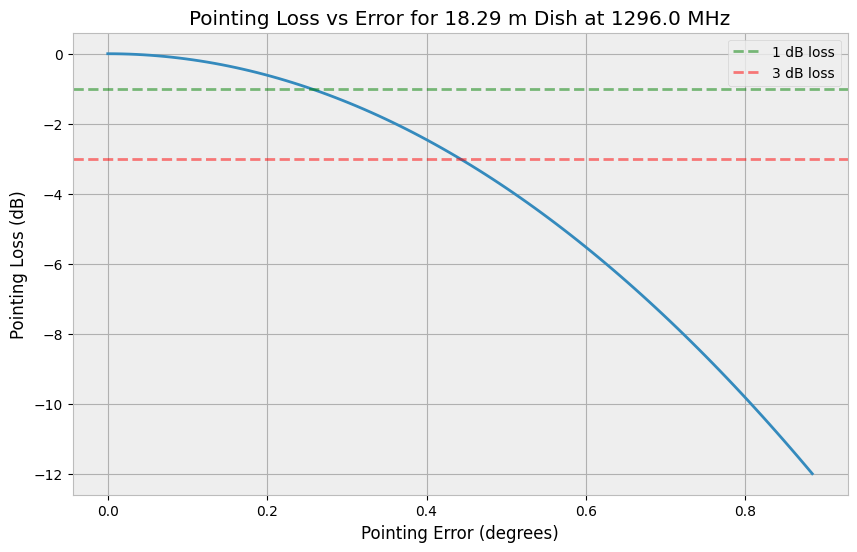

In [90]:
# Plot pointing loss vs tracking error normalized by beamwidth
errors, losses = analyzer.pointing_loss_vs_error(max_error_deg=beamwidth)

plt.figure(figsize=(10, 6))
plt.plot(errors, losses)
plt.grid(True)
plt.xlabel('Pointing Error (degrees)')
plt.ylabel('Pointing Loss (dB)')
plt.title(f'Pointing Loss vs Error for {params.tx_antenna_diameter_m:.2f} m Dish at {analyzer.params.tx_frequency_mhz:.1f} MHz')

# Add horizontal lines for common loss thresholds
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.5, label='1 dB loss')
plt.axhline(y=-3, color='r', linestyle='--', alpha=0.5, label='3 dB loss')
plt.legend()
plt.show()

## Pointing Error as a function of Tracking Error Normalized by Beamwidth

This is an experimental section to try and quantify the tracking error. Pointing error and tracking error are two different things, but notice that we get the same numerical results. Feedback here welcome and encouraged. 

Loss at error/beamwidth = 1/5.66: -0.37 dB
Loss at error/beamwidth = 1/2: -3.00 dB
Loss at error/beamwidth = 1/5.66: -0.37 dB
Loss at error/beamwidth = 1/2: -3.00 dB


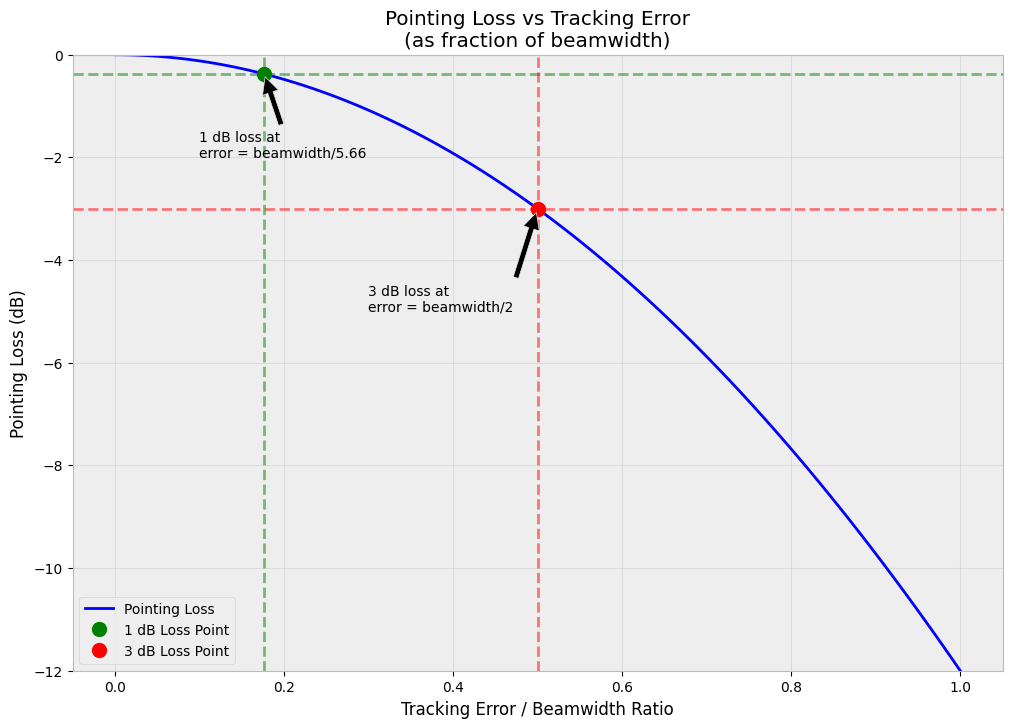


For your 18.29m dish at 0.0 MHz:
Beamwidth: 0.884°
Max tracking error for 1 dB loss: 0.156°
Max tracking error for 3 dB loss: 0.442°


In [91]:
# Cell 5: dish analysis of tracking error
#The visualization shows:
#The blue curve is the pointing loss vs tracking error (normalized to beamwidth)
#The green point shows where tracking error = beamwidth/5.66, giving 1 dB loss
#The red point shows where tracking error = beamwidth/2, giving 3 dB loss

#If your tracking error is less than beamwidth/5.66, your pointing loss is less than 1 dB
#At beamwidth/2, you've lost half your power (3 dB)
#The loss increases with the square of the error

def calculate_pointing_loss(error_angle, beamwidth):
    """Calculate pointing loss in dB given error angle and beamwidth"""
    return -12 * (error_angle / beamwidth)**2

# Create a range of error angles as fraction of beamwidth
error_fractions = np.linspace(0, 1, 100)

# Calculate losses
losses = calculate_pointing_loss(error_fractions, 1)

# Create the plot
plt.figure(figsize=(12, 8))

# Main loss curve
plt.plot(error_fractions, losses, 'b-', linewidth=2, label='Pointing Loss')

#Calculate losses at our specific points
loss_at_166 = calculate_pointing_loss(1/5.66, 1)
loss_at_half = calculate_pointing_loss(1/2, 1)

print(f"Loss at error/beamwidth = 1/5.66: {loss_at_166:.2f} dB")
print(f"Loss at error/beamwidth = 1/2: {loss_at_half:.2f} dB")

# Add markers for specific loss points
plt.plot(1/5.66, loss_at_166, 'go', markersize=10, label='1 dB Loss Point')
plt.plot(1/2, loss_at_half, 'ro', markersize=10, label='3 dB Loss Point')

# Add horizontal lines for loss levels
plt.axhline(y=loss_at_166, color='g', linestyle='--', alpha=0.5)
plt.axhline(y=loss_at_half, color='r', linestyle='--', alpha=0.5)

# Add vertical lines for error ratios
plt.axvline(x=1/5.66, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=1/2, color='r', linestyle='--', alpha=0.5)

# Customize the plot
plt.grid(True, alpha=0.3)
plt.xlabel('Tracking Error / Beamwidth Ratio')
plt.ylabel('Pointing Loss (dB)')
plt.title('Pointing Loss vs Tracking Error\n(as fraction of beamwidth)')

#Calculate losses at our specific points
loss_at_166 = calculate_pointing_loss(1/5.66, 1)
loss_at_half = calculate_pointing_loss(1/2, 1)

print(f"Loss at error/beamwidth = 1/5.66: {loss_at_166:.2f} dB")
print(f"Loss at error/beamwidth = 1/2: {loss_at_half:.2f} dB")

# Add text annotations
plt.annotate('1 dB loss at\nerror = beamwidth/5.66', 
            xy=(1/5.66, loss_at_166), xytext=(0.1, -2),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('3 dB loss at\nerror = beamwidth/2', 
            xy=(1/2, loss_at_half), xytext=(0.3, -5),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()

# Set y-axis limits to focus on relevant range
plt.ylim(-12, 0)

plt.show()

# Print example calculations for your specific dish
beamwidth = analyzer.beamwidth_deg()
print(f"\nFor your {params.tx_antenna_diameter_m:.2f}m dish at {params.tx_frequency_mhz/1e6:.1f} MHz:")
print(f"Beamwidth: {beamwidth:.3f}°")
print(f"Max tracking error for 1 dB loss: {beamwidth/5.66:.3f}°")
print(f"Max tracking error for 3 dB loss: {beamwidth/2:.3f}°")

## Link Budget at Minimum and Maximum Distance

Here is the CNR at a particular receiver bandwidth for minimum and maximum distance from Earth to Venus. 

In [92]:
# Cell 6: Print detailed results for minimum and maximum distances
min_results = calculator.calculate_link_budget(min_distance_km)
max_results = calculator.calculate_link_budget(max_distance_km)

print(f"Link Budget at Minimum Distance (38 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in min_results.items():
    print(f"{key}: {value:.2f}")

print(f"\nLink Budget at Maximum Distance (261 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in max_results.items():
    print(f"{key}: {value:.2f}")

Link Budget at Minimum Distance (38 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 31.76
tx_gain_db: 46.29
rx_gain_db: 46.29
free_space_loss_db: 492.59
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
system_noise_temperature: 47.80
rx_power_dbw: -220.45
noise_dbw: -161.80
cnr_db: -58.65

Link Budget at Maximum Distance (261 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 31.76
tx_gain_db: 46.29
rx_gain_db: 46.29
free_space_loss_db: 526.07
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
system_noise_temperature: 47.80
rx_power_dbw: -253.93
noise_dbw: -161.80
cnr_db: -92.12


## How much Doppler do we Have?

We will have to anticipate and "track out" Doppler and understand and tolerate a rate of change of this Doppler shift. A third factor is Doppler spread, which is what happens when a signal bounces off a rotating reflector. 

A Doppler spread penalty calculation is currently in the Mode Evaluator cell. 

How much Doppler do we have to deal with? This section calculates Doppler shift and the rate of change of the Doppler shift, and visualizes the results. 

Calculating Doppler for current time: 2025-03-01 18:48:26.088021+00:00
Current Earth-Venus:
  Relative velocity: -8651.07 m/s
  Doppler shift: 37398.50 Hz
  Received frequency: 1296.037399 MHz

Doppler shift rate of change (next 24 hours):
  Rate: -49.32 Hz/hour or -0.0137 Hz/second
  Starting Doppler: 37398.50 Hz
  Ending Doppler: 36214.87 Hz
  Total change: -1183.63 Hz

Calculating worst-case Doppler scenarios for a complete orbit cycle...
Worst-case Doppler shift:
  Maximum (positive) shift: 59965.10 Hz on 2026-08-04 12:48:26.128038+00:00
  Minimum (negative) shift: -60143.28 Hz on 2025-06-03 12:48:26.128038+00:00
  Total Doppler range: 120108.38 Hz

Worst-case Doppler rate of change:
  Maximum rate: -92.75 Hz/hour or -0.025764 Hz/second
  Occurs on: 2025-03-22 18:48:26.128038+00:00

Generating Doppler curve from 2025-03-01 18:48:31.802243+00:00 to 2025-03-31 18:48:31.802243+00:00


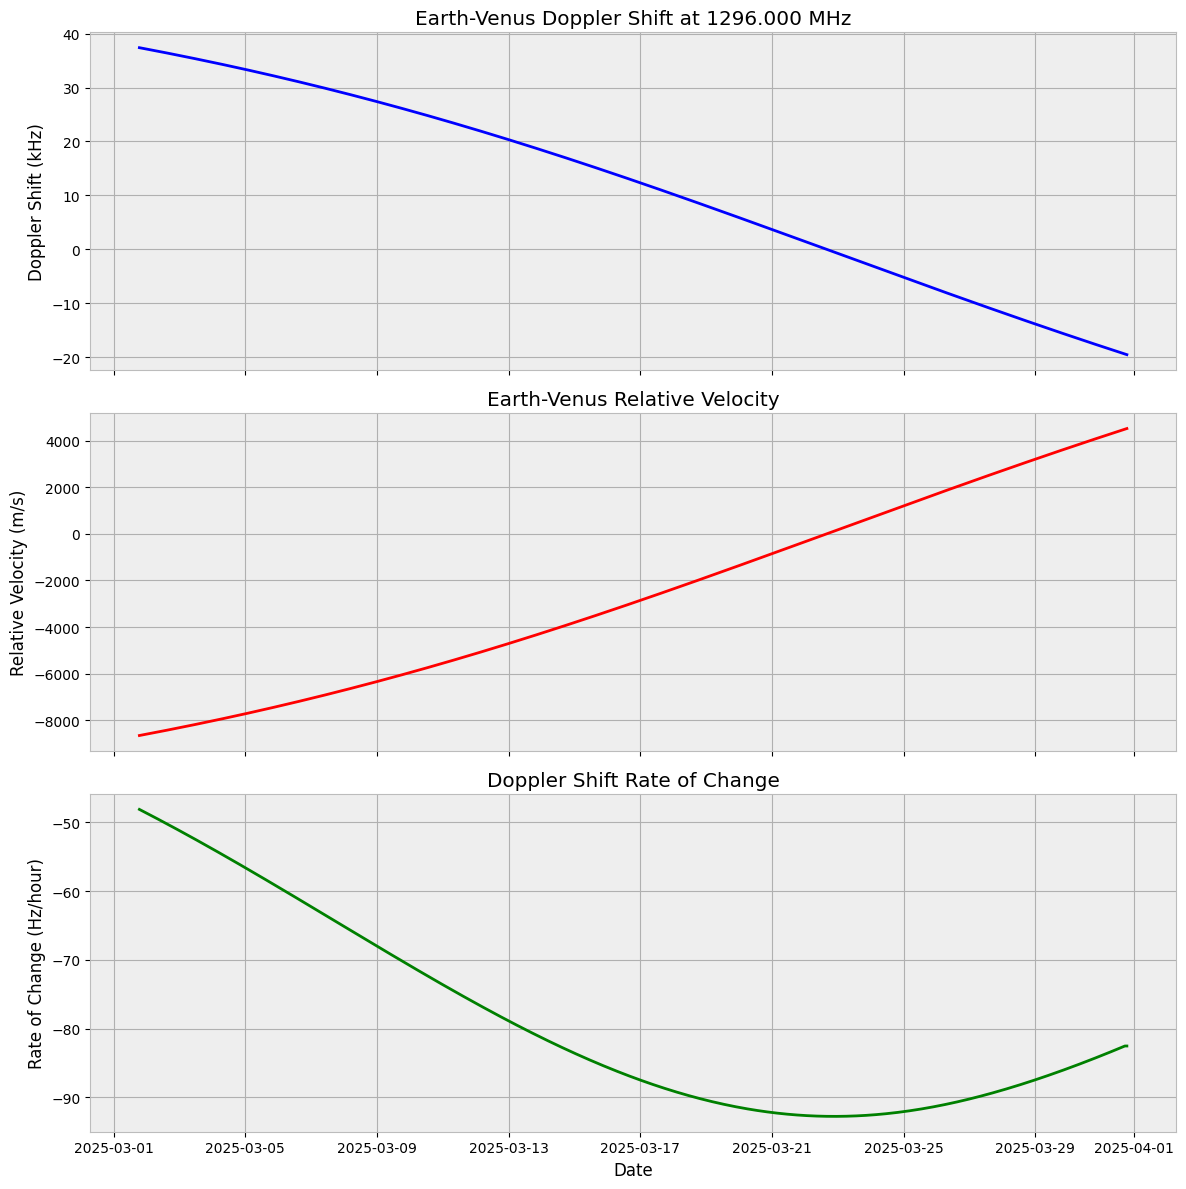

In [93]:
import numpy as np
from skyfield.api import load, wgs84
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

class DopplerCalculator:
    """
    A class to calculate Doppler shift between Earth and Venus.
    
    This class uses the Skyfield library to obtain planetary ephemeris data
    from publicly available sources and calculate the relative velocity and
    resulting Doppler shift for radio communications.
    """
    
    def __init__(self, frequency_mhz=1296.0):
        """
        Initialize the Doppler calculator with a specified frequency.
        
        Parameters:
        -----------
        frequency_mhz : float
            The transmission frequency in MHz (default: 1296.0 MHz)
        """
        # Speed of light in m/s
        self.c = 299792458.0
        
        # Convert MHz to Hz for calculations
        self.frequency_hz = frequency_mhz * 1e6
        
        # Load ephemeris data
        self.ephemeris = load('de421.bsp')
        self.earth = self.ephemeris['earth']
        self.venus = self.ephemeris['venus']
        
        # Time scale
        self.ts = load.timescale()
    
    def set_frequency(self, frequency_mhz):
        """
        Update the transmission frequency.
        
        Parameters:
        -----------
        frequency_mhz : float
            The new transmission frequency in MHz
        """
        self.frequency_hz = frequency_mhz * 1e6
    
    def calculate_doppler(self, timestamp=None):
        """
        Calculate the Doppler shift at a specific time.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time at which to calculate the Doppler shift (default: current time)
            If timezone-naive, UTC will be assumed
            
        Returns:
        --------
        tuple:
            - Frequency shift in Hz
            - Received frequency in Hz
            - Relative velocity in m/s (positive: moving apart, negative: moving closer)
        """
        if timestamp is None:
            # Make sure we use timezone-aware UTC time
            timestamp = datetime.now(timezone.utc)
        elif timestamp.tzinfo is None:
            # If the timestamp is naive (no timezone), assume it's in UTC
            timestamp = timestamp.replace(tzinfo=timezone.utc)
        
        # Convert to Skyfield time using the decomposed approach
        t = self.ts.utc(timestamp.year, timestamp.month, timestamp.day,
                        timestamp.hour, timestamp.minute, timestamp.second + timestamp.microsecond/1000000.0)
        
        # Get the position and velocity vectors
        earth_pos = self.earth.at(t)
        venus_pos = self.venus.at(t)
        
        # Calculate relative position and velocity
        relative = earth_pos.observe(self.venus)
        distance = relative.distance().km
        relative_velocity = relative.velocity.km_per_s
        
        # The radial velocity component (positive means moving apart)
        radial_velocity = np.dot(relative_velocity, relative.position.km / distance)
        
        # Convert km/s to m/s
        radial_velocity_m_s = radial_velocity * 1000
        
        # Calculate Doppler shift
        # If objects are moving apart (positive velocity), frequency decreases
        doppler_shift = -self.frequency_hz * radial_velocity_m_s / self.c
        received_frequency = self.frequency_hz + doppler_shift
        
        return doppler_shift, received_frequency, radial_velocity_m_s
    
    def calculate_doppler_rate(self, timestamp=None, delta_hours=24):
        """
        Calculate the rate of change of the Doppler shift over a specified time period.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time at which to start the calculation (default: current time)
            If timezone-naive, UTC will be assumed
        delta_hours : float, optional
            The time period in hours over which to calculate the rate (default: 24 hours)
            
        Returns:
        --------
        tuple:
            - Rate of Doppler shift change in Hz/hour
            - Rate of Doppler shift change in Hz/second
            - Doppler shift at start time in Hz
            - Doppler shift at end time in Hz
        """
        if timestamp is None:
            timestamp = datetime.now(timezone.utc)
        elif timestamp.tzinfo is None:
            timestamp = timestamp.replace(tzinfo=timezone.utc)
        
        # Calculate Doppler shift at the start time
        doppler_start, _, _ = self.calculate_doppler(timestamp)
        
        # Calculate Doppler shift at the end time
        end_time = timestamp + timedelta(hours=delta_hours)
        doppler_end, _, _ = self.calculate_doppler(end_time)
        
        # Calculate the rate of change
        delta_doppler = doppler_end - doppler_start
        rate_per_hour = delta_doppler / delta_hours
        rate_per_second = rate_per_hour / 3600
        
        return rate_per_hour, rate_per_second, doppler_start, doppler_end
    
    def generate_doppler_curve(self, start_date, end_date, num_points=100):
        """
        Generate a curve of Doppler shift over a time period.
        
        Parameters:
        -----------
        start_date : datetime
            The starting date for the curve (if timezone-naive, UTC will be assumed)
        end_date : datetime
            The ending date for the curve (if timezone-naive, UTC will be assumed)
        num_points : int, optional
            Number of points to calculate (default: 100)
            
        Returns:
        --------
        tuple:
            - List of datetime objects
            - List of Doppler shifts in Hz
            - List of relative velocities in m/s
        """
        # Ensure both dates have timezone information
        if start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        if end_date.tzinfo is None:
            end_date = end_date.replace(tzinfo=timezone.utc)
        
        time_delta = (end_date - start_date) / num_points
        
        times = []
        doppler_shifts = []
        velocities = []
        
        for i in range(num_points + 1):
            current_time = start_date + i * time_delta
            try:
                doppler_shift, _, velocity = self.calculate_doppler(current_time)
                
                times.append(current_time)
                doppler_shifts.append(doppler_shift)
                velocities.append(velocity)
            except Exception as e:
                print(f"Error calculating Doppler at time {current_time}: {e}")
                # Continue with the loop but skip this problematic point
                continue
        
        return times, doppler_shifts, velocities
    
    def calculate_worst_case_doppler(self, start_date=None, duration_days=584):
        """
        Calculate the worst-case Doppler shift and rate of change over a complete synodic period.
        
        The synodic period of Venus is approximately 584 days (the time it takes for Earth
        and Venus to return to the same relative positions).
        
        Parameters:
        -----------
        start_date : datetime, optional
            The starting date for the analysis (default: current time)
        duration_days : int, optional
            The duration in days to analyze (default: 584, one synodic period)
            
        Returns:
        --------
        dict:
            Dictionary containing:
            - max_doppler_shift: Maximum absolute Doppler shift in Hz
            - min_doppler_shift: Minimum Doppler shift in Hz (most negative)
            - max_doppler_shift_date: Date of maximum Doppler shift
            - min_doppler_shift_date: Date of minimum Doppler shift
            - max_rate: Maximum absolute rate of change in Hz/hour
            - max_rate_date: Date of maximum rate of change
            - max_rate_per_second: Maximum rate in Hz/second
            - total_doppler_range: Total range of Doppler shift in Hz
        """
        if start_date is None:
            start_date = datetime.now(timezone.utc)
        elif start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        
        end_date = start_date + timedelta(days=duration_days)
        
        # Use enough points to get good resolution (at least one point per day)
        num_points = max(1000, duration_days * 4)
        
        times, shifts, velocities = self.generate_doppler_curve(start_date, end_date, num_points)
        
        # Calculate rates of change
        rates = []
        rate_times = []
        
        for i in range(len(shifts) - 1):
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
            rate_times.append(times[i])
        
        # Find extremes for Doppler shift
        max_shift_idx = np.argmax(shifts)
        min_shift_idx = np.argmin(shifts)
        max_shift = shifts[max_shift_idx]
        min_shift = shifts[min_shift_idx]
        max_shift_date = times[max_shift_idx]
        min_shift_date = times[min_shift_idx]
        
        # Find extreme for rate of change (maximum absolute value)
        abs_rates = np.abs(rates)
        max_rate_idx = np.argmax(abs_rates)
        max_rate = rates[max_rate_idx]
        max_rate_date = rate_times[max_rate_idx]
        max_rate_per_second = max_rate / 3600
        
        # Calculate total Doppler range
        total_doppler_range = max_shift - min_shift
        
        return {
            'max_doppler_shift': max_shift,
            'min_doppler_shift': min_shift,
            'max_doppler_shift_date': max_shift_date,
            'min_doppler_shift_date': min_shift_date,
            'max_rate': max_rate,
            'max_rate_date': max_rate_date,
            'max_rate_per_second': max_rate_per_second,
            'total_doppler_range': total_doppler_range
        }
    
    def plot_doppler_curve(self, start_date, end_date, num_points=100, save_path=None, include_rate=True):
        """
        Generate and plot a curve of Doppler shift over a time period.
        
        Parameters:
        -----------
        start_date : datetime
            The starting date for the curve
        end_date : datetime
            The ending date for the curve
        num_points : int, optional
            Number of points to calculate (default: 100)
        save_path : str, optional
            Path to save the plot (default: None, plot is displayed instead)
        include_rate : bool, optional
            Whether to include a subplot showing the rate of change (default: True)
        """
        times, shifts, velocities = self.generate_doppler_curve(start_date, end_date, num_points)
        
        # Calculate rate of change for each point except the last one
        rates = []
        for i in range(len(shifts) - 1):
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
        
        # Add a placeholder for the last point to keep the arrays the same length
        rates.append(rates[-1] if rates else 0)  
        
        # Determine the number of subplots
        n_plots = 3 if include_rate else 2
        
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots), sharex=True)
        
        # Plot Doppler shift
        axes[0].plot(times, [s/1000 for s in shifts], 'b-')
        axes[0].set_ylabel('Doppler Shift (kHz)')
        axes[0].set_title(f'Earth-Venus Doppler Shift at {self.frequency_hz/1e6:.3f} MHz')
        axes[0].grid(True)
        
        # Plot velocity
        axes[1].plot(times, velocities, 'r-')
        axes[1].set_ylabel('Relative Velocity (m/s)')
        axes[1].set_title('Earth-Venus Relative Velocity')
        axes[1].grid(True)
        
        # Plot rate of change if requested
        if include_rate:
            axes[2].plot(times, rates, 'g-')
            axes[2].set_xlabel('Date')
            axes[2].set_ylabel('Rate of Change (Hz/hour)')
            axes[2].set_title('Doppler Shift Rate of Change')
            axes[2].grid(True)
        else:
            axes[1].set_xlabel('Date')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()


# Example usage
if __name__ == "__main__":
    # Create a calculator with the default 1296 MHz frequency
    DopplerCalculator = DopplerCalculator()
    
    # Calculate current Doppler shift - explicitly using UTC time
    current_time_utc = datetime.now(timezone.utc)
    print(f"Calculating Doppler for current time: {current_time_utc}")
    shift, freq, velocity = DopplerCalculator.calculate_doppler(current_time_utc)
    print(f"Current Earth-Venus:")
    print(f"  Relative velocity: {velocity:.2f} m/s")
    print(f"  Doppler shift: {shift:.2f} Hz")
    print(f"  Received frequency: {freq/1e6:.6f} MHz")
    
    # Calculate the rate of change of Doppler shift over the next 24 hours
    rate_hour, rate_sec, doppler_start, doppler_end = DopplerCalculator.calculate_doppler_rate(current_time_utc)
    print(f"\nDoppler shift rate of change (next 24 hours):")
    print(f"  Rate: {rate_hour:.2f} Hz/hour or {rate_sec:.4f} Hz/second")
    print(f"  Starting Doppler: {doppler_start:.2f} Hz")
    print(f"  Ending Doppler: {doppler_end:.2f} Hz")
    print(f"  Total change: {doppler_end - doppler_start:.2f} Hz")
    
    # Calculate worst-case Doppler scenarios
    print(f"\nCalculating worst-case Doppler scenarios for a complete orbit cycle...")
    worst_case = DopplerCalculator.calculate_worst_case_doppler()
    
    print(f"Worst-case Doppler shift:")
    print(f"  Maximum (positive) shift: {worst_case['max_doppler_shift']:.2f} Hz on {worst_case['max_doppler_shift_date']}")
    print(f"  Minimum (negative) shift: {worst_case['min_doppler_shift']:.2f} Hz on {worst_case['min_doppler_shift_date']}")
    print(f"  Total Doppler range: {worst_case['total_doppler_range']:.2f} Hz")
    
    print(f"\nWorst-case Doppler rate of change:")
    print(f"  Maximum rate: {worst_case['max_rate']:.2f} Hz/hour or {worst_case['max_rate_per_second']:.6f} Hz/second")
    print(f"  Occurs on: {worst_case['max_rate_date']}")
    
    # Generate a Doppler curve for the next 30 days - explicitly using UTC
    start = datetime.now(timezone.utc)
    end = start + timedelta(days=30)
    
    print(f"\nGenerating Doppler curve from {start} to {end}")
    DopplerCalculator.plot_doppler_curve(start, end, num_points=500)

## Reflection and Loss Analysis Worksheet

These calculations walk through the reflection loss and billboard gain of Venus and the Moon. Results have been provisionally moved (pending more review) to the EVELinkBudget Class. 

In [94]:
# Worksheet to play around with the reflection and loss analysis.
# Results here are moved into the mainline code.
class BillboardReflectionAnalysis:
    def __init__(self, tx_frequency_mhz: float = 1296.0):
        self.frequency = tx_frequency_mhz * 1e6
        self.c = 299792458
        self.wavelength = self.c / self.frequency
        
        # Target characteristics
        self.venus_radius_km = 6051.8
        self.moon_radius_km = 1737.4
        self.venus_albedo = 0.15
        self.moon_albedo = 0.07
        self.venus_atm_loss_db = 0.5
    
    def calculate_reflection_loss(self, albedo: float) -> float:
        """Calculate loss due to surface reflection"""
        return 10 * np.log10(albedo)
    
    def billboard_gain(self, radius_km: float, libration_angle_deg: float = 0) -> dict:
        """Calculate billboard gain for a disc reflector"""
        radius_m = radius_km * 1000
        
        # Adjust for libration
        libration_factor = np.cos(np.radians(libration_angle_deg))
        effective_area = np.pi * radius_m**2 * libration_factor
        
        # Billboard gain
        gain = 4 * np.pi * (effective_area / (self.wavelength**2))
        gain_db = 10 * np.log10(gain)
        
        return {
            'theoretical_gain_db': gain_db,
            'libration_factor_db': 10 * np.log10(libration_factor),
            'total_gain_db': gain_db + 10 * np.log10(libration_factor)
        }
    
    def complete_analysis(self, libration_angle_deg: float = 0):
        """Complete reflection analysis for both bodies as disc reflectors"""
        # Moon analysis
        moon_refl_loss = self.calculate_reflection_loss(self.moon_albedo)
        moon_billboard = self.billboard_gain(self.moon_radius_km, libration_angle_deg)
        moon_total = moon_billboard['total_gain_db'] + moon_refl_loss
        
        # Venus analysis (using same billboard approach)
        venus_refl_loss = self.calculate_reflection_loss(self.venus_albedo)
        venus_billboard = self.billboard_gain(self.venus_radius_km, libration_angle_deg)
        venus_total = venus_billboard['total_gain_db'] + venus_refl_loss + self.venus_atm_loss_db
        
        print(f"\nReflection Analysis at {self.frequency/1e6:.1f} MHz (Billboard Model):")
        
        print("\nMoon Analysis:")
        print(f"Billboard Gain: {moon_billboard['total_gain_db']:.1f} dB")
        print(f"Surface Reflection Loss: {moon_refl_loss:.1f} dB")
        print(f"Total Effect: {moon_total:.1f} dB")
        
        print("\nVenus Analysis:")
        print(f"Billboard Gain: {venus_billboard['total_gain_db']:.1f} dB")
        print(f"Surface Reflection Loss: {venus_refl_loss:.1f} dB")
        print(f"Atmospheric Loss: {self.venus_atm_loss_db:.1f} dB")
        print(f"Total Effect: {venus_total:.1f} dB")
        
        # Calculate effective cross-sectional areas
        moon_area = np.pi * (self.moon_radius_km * 1000)**2
        venus_area = np.pi * (self.venus_radius_km * 1000)**2
        print(f"\nRelative Size Comparison:")
        print(f"Venus/Moon area ratio: {venus_area/moon_area:.1f}")
        
        return {
            'moon': {'billboard': moon_billboard, 'reflection_loss': moon_refl_loss, 'total': moon_total},
            'venus': {'billboard': venus_billboard, 'reflection_loss': venus_refl_loss, 'total': venus_total}
        }

# Create analyzer and run analysis
analyzer = BillboardReflectionAnalysis(params.tx_frequency_mhz)
results = analyzer.complete_analysis(libration_angle_deg=3)

# Calculate path losses for total effect
moon_distance_km = 384400
venus_min_distance_km = 38_000_000
venus_max_distance_km = 261_000_000

def path_loss(distance_km, frequency_hz):
    wavelength = 299792458 / frequency_hz
    distance_m = distance_km * 1000
    return 40 * np.log10(4 * np.pi * distance_m / wavelength)  # Two-way path loss

print("\nPath Loss Comparison:")
print(f"Moon ({moon_distance_km:,} km): {path_loss(moon_distance_km, analyzer.frequency):.1f} dB")
print(f"Venus min ({venus_min_distance_km:,} km): {path_loss(venus_min_distance_km, analyzer.frequency):.1f} dB")
print(f"Venus max ({venus_max_distance_km:,} km): {path_loss(venus_max_distance_km, analyzer.frequency):.1f} dB")

# Calculate total path effects
moon_total = results['moon']['total'] - path_loss(moon_distance_km, analyzer.frequency)
venus_min_total = results['venus']['total'] - path_loss(venus_min_distance_km, analyzer.frequency)
venus_max_total = results['venus']['total'] - path_loss(venus_max_distance_km, analyzer.frequency)

print("\nTotal Path Effects (Billboard Gain + Reflection Loss + Path Loss):")
print(f"Moon: {moon_total:.1f} dB")
print(f"Venus (minimum distance): {venus_min_total:.1f} dB")
print(f"Venus (maximum distance): {venus_max_total:.1f} dB")


Reflection Analysis at 1296.0 MHz (Billboard Model):

Moon Analysis:
Billboard Gain: 153.5 dB
Surface Reflection Loss: -11.5 dB
Total Effect: 141.9 dB

Venus Analysis:
Billboard Gain: 164.3 dB
Surface Reflection Loss: -8.2 dB
Atmospheric Loss: 0.5 dB
Total Effect: 156.6 dB

Relative Size Comparison:
Venus/Moon area ratio: 12.1

Path Loss Comparison:
Moon (384,400 km): 412.8 dB
Venus min (38,000,000 km): 492.6 dB
Venus max (261,000,000 km): 526.1 dB

Total Path Effects (Billboard Gain + Reflection Loss + Path Loss):
Moon: -270.9 dB
Venus (minimum distance): -336.0 dB
Venus (maximum distance): -369.5 dB


## Mode Analysis

This class does an analysis of potential modes and their suitability for the the link. 

The relationship between the CNR from the link budget object (calculated at the operational receiver bandwidth) and SNR of particular signals (given at a different bandwidth) is needed.

SNR = CNR × (BW_CNR / BW_SNR)


In [95]:
import numpy as np
import pandas as pd

class AmateurRadioModeEvaluator:
    """
    A class to evaluate the suitability of amateur radio modes based on link parameters. 
    """
    
    def __init__(self, params: DSESLinkParameters):
        self.params = params        
        # Define common amateur radio modes with their characteristics
        self.modes = [
            {"name": "CW", "bandwidth_hz": 250, "required_snr_db": -15, "noise_bandwidth_hz": 250},
            {"name": "FT8", "bandwidth_hz": 50, "required_snr_db": -20, "noise_bandwidth_hz": 2500},
            {"name": "JT65", "bandwidth_hz": 2.7, "required_snr_db": -25, "noise_bandwidth_hz": 2500},
            {"name": "SSB", "bandwidth_hz": 2500, "required_snr_db": 8, "noise_bandwidth_hz": 2500},
            {"name": "FM", "bandwidth_hz": 12500, "required_snr_db": 12, "noise_bandwidth_hz": 12500},
            {"name": "RTTY", "bandwidth_hz": 250, "required_snr_db": 5, "noise_bandwidth_hz": 250},
            {"name": "PSK31", "bandwidth_hz": 31, "required_snr_db": 4, "noise_bandwidth_hz": 31},
            {"name": "FT4", "bandwidth_hz": 90, "required_snr_db": -17, "noise_bandwidth_hz": 2500},
            {"name": "JS8", "bandwidth_hz": 30, "required_snr_db": -18, "noise_bandwidth_hz": 2500},

            # WSPR Modes
            {"name": "WSPR-15", "bandwidth_hz": 6, "required_snr_db": -32, "noise_bandwidth_hz": 2500},   # 15-minute
            {"name": "WSPR-2", "bandwidth_hz": 6, "required_snr_db": -28, "noise_bandwidth_hz": 2500},    # 2-minute mode (classic WSPR mode??)
            {"name": "WSPR-120", "bandwidth_hz": 6, "required_snr_db": -37, "noise_bandwidth_hz": 2500},  # 120-minute mode,
            {"name": "WSPR-LF", "bandwidth_hz": 6, "required_snr_db": -30, "noise_bandwidth_hz": 2500},   # Low frequency band modes (??)
            {"name": "WSPR-H", "bandwidth_hz": 12, "required_snr_db": -26, "noise_bandwidth_hz": 2500},   # High-speed variant with doubled bandwidth
            
            # Q65 modes (various submodes A-E with different tone spacing and durations)
            {"name": "Q65-15A", "bandwidth_hz": 65, "required_snr_db": -26, "noise_bandwidth_hz": 2500},  # 15-second mode A
            {"name": "Q65-30A", "bandwidth_hz": 65, "required_snr_db": -27, "noise_bandwidth_hz": 2500},  # 30-second mode A
            {"name": "Q65-60A", "bandwidth_hz": 65, "required_snr_db": -28, "noise_bandwidth_hz": 2500},  # 60-second mode A
            {"name": "Q65-120A", "bandwidth_hz": 65, "required_snr_db": -29, "noise_bandwidth_hz": 2500}, # 120-second mode A
            {"name": "Q65-300A", "bandwidth_hz": 65, "required_snr_db": -30, "noise_bandwidth_hz": 2500}, # 300-second mode A
            
            {"name": "Q65-15B", "bandwidth_hz": 90, "required_snr_db": -26, "noise_bandwidth_hz": 2500},  # Mode B - [ ] wider tone spacing
            {"name": "Q65-30B", "bandwidth_hz": 90, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60B", "bandwidth_hz": 90, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120B", "bandwidth_hz": 90, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300B", "bandwidth_hz": 90, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15C", "bandwidth_hz": 180, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode C - [ ] even wider spacing
            {"name": "Q65-30C", "bandwidth_hz": 180, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60C", "bandwidth_hz": 180, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120C", "bandwidth_hz": 180, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300C", "bandwidth_hz": 180, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15D", "bandwidth_hz": 360, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode D
            {"name": "Q65-30D", "bandwidth_hz": 360, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60D", "bandwidth_hz": 360, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120D", "bandwidth_hz": 360, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300D", "bandwidth_hz": 360, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15E", "bandwidth_hz": 720, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode E - [ ] widest spacing
            {"name": "Q65-30E", "bandwidth_hz": 720, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60E", "bandwidth_hz": 720, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120E", "bandwidth_hz": 720, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300E", "bandwidth_hz": 720, "required_snr_db": -30, "noise_bandwidth_hz": 2500}
        ]
    
    def add_mode(self, name, bandwidth_hz, required_snr_db):
        """
        Add a new mode to the evaluator.
        
        Parameters:
        name (str): Name of the mode
        bandwidth_hz (float): Bandwidth of the mode in Hz
        required_snr_db (float): Required SNR in dB for the mode to function
        noise_bandwidth_hz (float): over what bandwidth is the required_snr_db given?
        """
        new_mode = {
            "name": name,
            "bandwidth_hz": bandwidth_hz,
            "required_snr_db": required_snr_db,
            "noise_bandwidth_hz": noise_bandwidth_hz
        }
        self.modes.append(new_mode)
    
    def evaluate_modes(self, cnr_db, receiver_noise_bandwidth, doppler_spread_hz=None):
        """
        Evaluate suitability of amateur radio modes based on link CNR
        
        Parameters:
        cnr_db (float): Carrier-to-Noise Ratio in dB already calculated at receiver_noise_bandwidth
        receiver_noise_bandwidth (float): Receiver noise bandwidth in Hz used for the CNR calculation
        doppler_spread_hz (float, optional): Doppler spread in Hz, if we have it
        
        Returns:
        DataFrame: Modes with suitability assessment
        """
        results = []

        # Scale our CNR result from link budget calculator to 1Hz
        bandwidth_factor_db = 10 * np.log10(receiver_noise_bandwidth / 1)
        cnr_db_1hz = cnr_db + bandwidth_factor_db
        print(f"We have {min_cnr:.2f} dB CNR at {params.receiver_noise_bandwidth} Hz receiver noise bandwidth.\n")
        print(f"We have {cnr_db_1hz:.2f} dB CNR at 1Hz.\n")


        for mode in self.modes:
            # Scale each mode SNR from noise bandwidth to 1Hz bandwidth
            #bandwidth_factor_db = 10 * np.log10(mode["bandwidth_hz"] / 1 )
            #snr_db_1hz = mode["required_snr_db"] + bandwidth_factor_db
            
            # Some SNRs are taken really at 2500 Hz, and some are not. 
            # We made a table column to handle it. 
            # noise_bandwidth_hz is the "real" number to scale by. 
            snr_db_1hz = mode["required_snr_db"] + 10 * np.log10(mode["noise_bandwidth_hz"])
            
            # Apply Doppler spread penalty if applicable (needs review because Google says I can't do this)
            doppler_penalty_db = 0
            #'''
            if doppler_spread_hz is not None and doppler_spread_hz > 0:
                # If Doppler spread exceeds mode bandwidth, apply penalty
                if doppler_spread_hz > mode["bandwidth_hz"]:
                    # Simple model: penalty proportional to how much Doppler exceeds bandwidth.
                    # Claim:
                    # The Doppler spread penalty is being calculated as a ratio between 
                    # the actual Doppler spread (in Hz) and the mode's bandwidth (also Hz).
                    # This ratio is dimensionless (Hz/Hz), so it doesn't need scaling to 1Hz
                    # The 10*log10() turns this ratio into a straight up d
                    doppler_penalty_db = 10 * np.log10(doppler_spread_hz / mode["bandwidth_hz"])
                    # Cap the penalty so things don't get out of hand here - arbitrary 20 dB
                    doppler_penalty_db = min(doppler_penalty_db, 20)
                    #'''
            
            # Calculate final effective SNR in 1Hz with Doppler penalty
            effective_snr_db_1hz = snr_db_1hz + doppler_penalty_db
            
            # Calculate margin between CNR in 1Hz and required SNR for mode in 1Hz
            margin_db = cnr_db_1hz - effective_snr_db_1hz
            
            # Determine reliability level
            if margin_db >= 10:
                reliability = "Excellent"
            elif margin_db >= 6:
                reliability = "Very Good"
            elif margin_db >= 3:
                reliability = "Good"
            elif margin_db >= 0:
                reliability = "Marginal"
            else:
                reliability = "Not Feasible"
            
            result = {
                "Mode": mode["name"],
                "Mode Bandwidth (Hz)": mode["bandwidth_hz"],
                "Mode SNR (dB)": mode["required_snr_db"],
                "Mode SNR 1hz (dB)": round(effective_snr_db_1hz, 1),
                "Margin (dB)": round(margin_db, 1),
                "Reliability": reliability,
                "Feasible": margin_db >= 0
            }
            
            # Add Doppler information if provided
            if doppler_spread_hz is not None:
                result["Doppler Spread (Hz)"] = doppler_spread_hz
                result["Doppler Penalty (dB)"] = round(doppler_penalty_db, 1)
            
            results.append(result)
        
        # Convert to DataFrame for easy display - [ ] thank you Rose!
        results_df = pd.DataFrame(results)
        
        # Sort by margin (highest first)
        results_df = results_df.sort_values(by="Margin (dB)", ascending=False)
        
        return results_df
    
    def filter_by_mode_type(self, results_df, mode_type):
        """
        Filter results by mode type (e.g., 'Q65', 'WSPR', etc.)
        
        Parameters:
        results_df (DataFrame): Results from evaluate_modes
        mode_type (str): Mode type to filter for
        
        Returns:
        DataFrame: Filtered results
        """
        return results_df[results_df['Mode'].str.contains(mode_type)]
    
    def get_feasible_modes(self, results_df):
        """
        Get only feasible modes from results
        
        Parameters:
        results_df (DataFrame): Results from evaluate_modes
        
        Returns:
        DataFrame: Only feasible modes
        """
        return results_df[results_df['Feasible'] == True]


# candidate for some improvement but this is how we'll fetch CNR for now. 
min_distance_km = 38_000_000  # Minimum Earth-Venus distance
max_distance_km = 261_000_000  # Maximum Earth-Venus distance
# Get our link budget CNR values from earlier calculations
min_results = calculator.calculate_link_budget(min_distance_km)
max_results = calculator.calculate_link_budget(max_distance_km)
min_cnr = min_results['cnr_db']
max_cnr = max_results['cnr_db']
        
# Example usage:
evaluator = AmateurRadioModeEvaluator(params)
results = evaluator.evaluate_modes(min_cnr, params.receiver_noise_bandwidth)
print(results.to_string())

print(f"\n\n\n")

# # With Doppler:
results_with_doppler = evaluator.evaluate_modes(min_cnr, params.receiver_noise_bandwidth, doppler_spread_hz=30)
print(results_with_doppler.to_string())

print(f"\n\n\n")

# # Filter for specific mode types:
q65_modes = evaluator.filter_by_mode_type(results, 'Q65')
print(q65_modes.to_string())

print(f"\n\n\n")

# # Only feasible modes - no Doppler
only_feasible_results = evaluator.get_feasible_modes(results)
print(only_feasible_results.to_string())

print(f"\n\n\n")

# # Only feasible modes - with Doppler
only_feasible_results = evaluator.get_feasible_modes(results_with_doppler)
print(only_feasible_results.to_string())

We have -58.65 dB CNR at 100000.0 Hz receiver noise bandwidth.

We have -8.65 dB CNR at 1Hz.

        Mode  Mode Bandwidth (Hz)  Mode SNR (dB)  Mode SNR 1hz (dB)  Margin (dB)   Reliability  Feasible
11  WSPR-120                  6.0            -37               -3.0         -5.6  Not Feasible     False
9    WSPR-15                  6.0            -32                2.0        -10.6  Not Feasible     False
38  Q65-300E                720.0            -30                4.0        -12.6  Not Feasible     False
33  Q65-300D                360.0            -30                4.0        -12.6  Not Feasible     False
18  Q65-300A                 65.0            -30                4.0        -12.6  Not Feasible     False
12   WSPR-LF                  6.0            -30                4.0        -12.6  Not Feasible     False
28  Q65-300C                180.0            -30                4.0        -12.6  Not Feasible     False
23  Q65-300B                 90.0            -30                4.

## System Noise Temperature Worksheet (Draft)

Trying to recreate the 70 k Tsys from the DSES worksheet. Numbers don't match so we should figure out why. 


Some notes on trying to move to a higher frequency, and whether the surface RMS estimation of 0.3mm could "hold":

At 1296 MHz:

Surface efficiency ≈ 98%

Very good performance, minimal scatter loss. 


At 2450 MHz:

Surface efficiency ≈ 98%

Does not seem to present a problem. 

Also, fmax = c / (16 × RMS) as a guideline, which gives a really large number.


In [96]:
from dataclasses import dataclass
from typing import Optional
import numpy as np

@dataclass
class SkyNoiseParams:
    """Parameters affecting sky noise temperature"""
    tx_frequency_mhz: float
    elevation_angle_deg: float
    atmospheric_conditions: str = 'clear'  # 'clear', 'cloudy', 'rain'

@dataclass
class AntennaParams:
    """Physical parameters of the antenna"""
    main_beam_efficiency: float
    spillover_efficiency: float
    surface_rms_mm: float
    diameter_m: float

class SystemNoiseCalculator:
    def __init__(self, antenna_params: AntennaParams):
        self.antenna = antenna_params
        
    def calculate_sky_noise(self, sky_params: SkyNoiseParams) -> float:
        """
        Calculate sky noise temperature based on frequency and elevation angle
        Using simplified atmospheric model - [ ] Jan King used the ITU model
        """
        # Convert elevation angle to radians
        elev_rad = np.radians(sky_params.elevation_angle_deg)
        
        # Basic atmospheric attenuation model (simplified)
        # We might want to try to incorporate more complex models like the one
        # Jan King uses in his excel spreadsheet (ITU). 
        base_temp = 2.7  # cosmic background radiation
        
        # Atmospheric contribution increases at lower elevation angles
        air_mass = 1.0 / np.sin(elev_rad)
        
        # Frequency dependent atmospheric absorption (simplified model!)
        freq_factor = 0.1 * (sky_params.tx_frequency_mhz / 1000) / 10.0  # Convert MHz to GHz for calculation
        
        # Weather condition factors
        weather_factors = {
            'clear': 1.0,
            'cloudy': 1.5,
            'rain': 3.0
        }
        
        weather_multiplier = weather_factors.get(sky_params.atmospheric_conditions, 1.0)
        
        return base_temp + (270 * (1 - np.exp(-freq_factor * air_mass))) * weather_multiplier

    def calculate_spillover_noise(self, ground_temp: float = 290.0) -> float:
        """Calculate spillover noise contribution"""
        return ground_temp * (1 - self.antenna.spillover_efficiency)

    def calculate_scatter_noise(self, tx_frequency_mhz: float) -> float:
        """Calculate scattering noise due to surface imperfections"""
        wavelength_mm = 300000 / tx_frequency_mhz  # Convert MHz to wavelength in mm
        surface_efficiency = np.exp(-(4 * np.pi * self.antenna.surface_rms_mm / wavelength_mm) ** 2) # surface efficiency, Ruze equation
        #print(f"{surface_efficiency}")
        return 290 * (1 - surface_efficiency)

    def calculate_system_noise(self, 
                             sky_params: SkyNoiseParams,
                             receiver_temp: float,
                             ground_temp: float = 290.0) -> dict:
        """
        Calculate total system noise temperature and its components
        
        Args:
            sky_params: Sky noise parameters
            receiver_temp: Receiver noise temperature in Kelvin
            ground_temp: Ground temperature in Kelvin (default 290K)
            
        Returns:
            Dictionary containing total and component temperatures
        """
        # Calculate individual components
        sky_noise = self.calculate_sky_noise(sky_params)
        spillover_noise = self.calculate_spillover_noise(ground_temp)
        scatter_noise = self.calculate_scatter_noise(sky_params.tx_frequency_mhz)
        
        # Calculate antenna temperature
        t_ant = (self.antenna.main_beam_efficiency * sky_noise + 
                spillover_noise + scatter_noise)
        
        # Calculate total system temperature
        t_sys = t_ant + receiver_temp
        
        return {
            'T_sys': t_sys,
            'T_ant': t_ant,
            'T_sky': sky_noise,
            'T_spillover': spillover_noise,
            'T_scatter': scatter_noise,
            'T_receiver': receiver_temp
        }

# Example usage
if __name__ == "__main__":
    # Define antenna parameters
    antenna = AntennaParams(
        main_beam_efficiency=0.69,  # Hoping this is the same as aperture efficiency - [ ] if not we need a number
        spillover_efficiency=0.95,  # 60-80 is typical for large dishes so I picked 70% at first. This is the percent
                                    # of what is transmitted that is actually reflected. Feed pattern doesn't perfectly 
                                    # match the dish surface. Thomas recommended 95% to reflect the better performance of 
                                    # space oriented dishes like the ones we're dealing with
        surface_rms_mm=0.3, # root mean square (RMS) deviation of the actual dish surface from an ideal parabolic shape. 
                            # Professional radio telescopes 0.1-0.3mm "A typical error budget [43] for the surface error 
                            # budget of a 34-m antenna is 0.3-mm root-sum-square (rss)." -Large Antennas of the Deep Space Network
                            # by William A. Imbriale
                            # Cheaper mesh dishes are 2mm or more
        diameter_m=18.2     # Physical dimensions of the dish. 
    )
    
    # Create calculator instance
    NoiseCalculator = SystemNoiseCalculator(antenna)
    
    # Define sky parameters
    sky = SkyNoiseParams(
        tx_frequency_mhz=1296.0,
        #tx_frequency_mhz=2450.0,
        elevation_angle_deg=45.0, # venus can be up to 40-60 degrees elevation - [ ] this can be a live number. 
        atmospheric_conditions='clear'
    )
    
    # Calculate system noise
    results = NoiseCalculator.calculate_system_noise(
        sky_params=sky,
        receiver_temp=28.0  # 0.4 dB NF Kuhne MKU LNA 132 AH SMA - [ ] fairly confident on this temperature
    )
    
    # Print results
    for key, value in results.items():
        print(f"{key}: {value:.1f} K")

T_sys: 47.8 K
T_ant: 19.8 K
T_sky: 7.6 K
T_spillover: 14.5 K
T_scatter: 0.1 K
T_receiver: 28.0 K
